# Machine Learning - Using SciKitLearn's Decision Tree Classifier Algorithm
## Data Preparation
### Importing the required dependencies. Psycopg2 is used to connect to the database on AWS.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import psycopg2 as pg
from config import aws_info
from sklearn import tree, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Pandas is used to query the database and create the required dataframes.

In [2]:
engine = pg.connect(database='project_cchange', host='finalproject.cgkd6swv7jef.us-east-2.rds.amazonaws.com', user='root', password='Pollito11!', port='5432')
df_metrics = pd.read_sql('select * from metrics', con=engine)
df_classifier = pd.read_sql('select * from country_income_class', con=engine)

## Preparation of the metrics dataframe.
### The columns that will be used in the model are selected into df_metrics_2

In [3]:
df_metrics_2 = df_metrics[['country_name', 'year', 'Total_Population','CO2_Emissions_by_Sector_Building',
       'CO2_Emissions_by_Sector_Bunker_Fuels',
       'CO2_Emissions_by_Sector_Electricity_Heat',
       'CO2_Emissions_by_Sector_Energy',
       'CCO2_Emissions_by_Sector_Industrial_Processes',
       'CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry',
       'CO2_Emissions_by_Sector_Manufacturing_Construction',
       'CO2_Emissions_by_Sector_Other_Fuel_Combustion','CO2_Emissions_by_Sector_Transportation', 'Net_Electricity_Consumption']]

### Null values will need to be dropped, so the number of values is counted to see approximately how many nulls there are in each column.

In [4]:
df_metrics_2.count()

country_name                                            8140
year                                                    8140
Total_Population                                        8043
CO2_Emissions_by_Sector_Building                        5049
CO2_Emissions_by_Sector_Bunker_Fuels                    5104
CO2_Emissions_by_Sector_Electricity_Heat                5201
CO2_Emissions_by_Sector_Energy                          5536
CCO2_Emissions_by_Sector_Industrial_Processes           4022
CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry    4676
CO2_Emissions_by_Sector_Manufacturing_Construction      4728
CO2_Emissions_by_Sector_Other_Fuel_Combustion           3813
CO2_Emissions_by_Sector_Transportation                  5353
Net_Electricity_Consumption                             6035
dtype: int64

In [5]:
df_metrics_3 = df_metrics_2.dropna(how='any')

In [6]:
df_metrics_3.count()

country_name                                            2868
year                                                    2868
Total_Population                                        2868
CO2_Emissions_by_Sector_Building                        2868
CO2_Emissions_by_Sector_Bunker_Fuels                    2868
CO2_Emissions_by_Sector_Electricity_Heat                2868
CO2_Emissions_by_Sector_Energy                          2868
CCO2_Emissions_by_Sector_Industrial_Processes           2868
CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry    2868
CO2_Emissions_by_Sector_Manufacturing_Construction      2868
CO2_Emissions_by_Sector_Other_Fuel_Combustion           2868
CO2_Emissions_by_Sector_Transportation                  2868
Net_Electricity_Consumption                             2868
dtype: int64

### The data types are checked as well as the head().

In [7]:
df_metrics_3.dtypes

country_name                                             object
year                                                      int64
Total_Population                                        float64
CO2_Emissions_by_Sector_Building                        float64
CO2_Emissions_by_Sector_Bunker_Fuels                    float64
CO2_Emissions_by_Sector_Electricity_Heat                float64
CO2_Emissions_by_Sector_Energy                          float64
CCO2_Emissions_by_Sector_Industrial_Processes           float64
CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry    float64
CO2_Emissions_by_Sector_Manufacturing_Construction      float64
CO2_Emissions_by_Sector_Other_Fuel_Combustion           float64
CO2_Emissions_by_Sector_Transportation                  float64
Net_Electricity_Consumption                             float64
dtype: object

In [8]:
df_metrics_3.head()

,country_name,year,Total_Population,CO2_Emissions_by_Sector_Building,CO2_Emissions_by_Sector_Bunker_Fuels,CO2_Emissions_by_Sector_Electricity_Heat,CO2_Emissions_by_Sector_Energy,CCO2_Emissions_by_Sector_Industrial_Processes,CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry,CO2_Emissions_by_Sector_Manufacturing_Construction,CO2_Emissions_by_Sector_Other_Fuel_Combustion,CO2_Emissions_by_Sector_Transportation,Net_Electricity_Consumption
46,Albania,1999,3108778.0,0.24,0.52,0.29,2.92,0.05,0.19,0.49,0.51,1.40,3.48
47,Albania,2000,3089027.0,0.25,0.53,0.38,3.08,0.09,0.19,0.47,0.51,1.47,3.76
50,Albania,2003,3039616.0,0.45,0.55,0.36,3.82,0.29,-1.12,0.50,0.60,1.92,4.11
51,Albania,2004,3026939.0,0.39,0.31,0.28,4.01,0.29,-1.12,0.55,0.49,2.30,4.05
52,Albania,2005,3011487.0,0.36,0.38,0.30,3.83,0.25,-1.12,0.45,0.34,2.37,3.74


### A unique count of the country names tells use how many countries were kept after dropping null values. The original number of countries in the dataframe was 220.

In [9]:
df_metrics_3['country_name'].nunique()

119

## Preparation of the classifier dataframe.
### The columns 'country_name' and 'year' are selected and will both be used to merge the two dataframes in order to assign an 'income_group' to each country and year of the metrics dataframe. The 'income_group' is the target label the classification model will be assigning. The countries are assigned a label of High Income (H), Upper Middle Income (UM), Lower Middle Income (LM), or Lower Income (L). These labels come directly from the World Bank income classification dataset.

In [10]:
df_classifier_1 = df_classifier[['country_name','year','income_group']]

### A value count of the 'income_group' column is generated to see how many data points are in each income group.

In [11]:
df_classifier_1['income_group'].value_counts()

H     1968
LM    1775
L     1532
UM    1389
..     310
Name: income_group, dtype: int64

### Null values are changed from '..' to Nan and then dropped.

In [12]:
df_classifier_2 = df_classifier_1.replace('..', np.nan, inplace=True)
df_classifier_3 = df_classifier_1.dropna(how='any')
df_classifier_3['income_group'].value_counts()

C:\Users\brend\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


H     1968
LM    1775
L     1532
UM    1389
Name: income_group, dtype: int64

### The datatypes and head() are inspected to ensure the dataframe is ready to merge.

In [13]:
df_classifier_3.head()

,country_name,year,income_group
0,Afghanistan,1990,L
1,Afghanistan,1991,L
2,Afghanistan,1992,L
3,Afghanistan,1993,L
4,Afghanistan,1994,L


In [14]:
df_classifier_3.dtypes

country_name    object
year             int64
income_group    object
dtype: object

### Pandas pd.merge() is used to join the tables on both the 'country_name' and 'year' columns.

In [15]:
df_joined = pd.merge(df_metrics_3,df_classifier_3,how = 'inner',on=['country_name','year'])

### The columns and head() are inspected, as well as a count of the total rows and unique countries.

In [16]:
df_joined.columns

Index(['country_name', 'year', 'Total_Population',
       'CO2_Emissions_by_Sector_Building',
       'CO2_Emissions_by_Sector_Bunker_Fuels',
       'CO2_Emissions_by_Sector_Electricity_Heat',
       'CO2_Emissions_by_Sector_Energy',
       'CCO2_Emissions_by_Sector_Industrial_Processes',
       'CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry',
       'CO2_Emissions_by_Sector_Manufacturing_Construction',
       'CO2_Emissions_by_Sector_Other_Fuel_Combustion',
       'CO2_Emissions_by_Sector_Transportation', 'Net_Electricity_Consumption',
       'income_group'],
      dtype='object')

In [17]:
df_joined.head()

,country_name,year,Total_Population,CO2_Emissions_by_Sector_Building,CO2_Emissions_by_Sector_Bunker_Fuels,CO2_Emissions_by_Sector_Electricity_Heat,CO2_Emissions_by_Sector_Energy,CCO2_Emissions_by_Sector_Industrial_Processes,CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry,CO2_Emissions_by_Sector_Manufacturing_Construction,CO2_Emissions_by_Sector_Other_Fuel_Combustion,CO2_Emissions_by_Sector_Transportation,Net_Electricity_Consumption,income_group
0,Albania,1999,3108778.0,0.24,0.52,0.29,2.92,0.05,0.19,0.49,0.51,1.40,3.48,LM
1,Albania,2000,3089027.0,0.25,0.53,0.38,3.08,0.09,0.19,0.47,0.51,1.47,3.76,LM
2,Albania,2003,3039616.0,0.45,0.55,0.36,3.82,0.29,-1.12,0.50,0.60,1.92,4.11,LM
3,Albania,2004,3026939.0,0.39,0.31,0.28,4.01,0.29,-1.12,0.55,0.49,2.30,4.05,LM
4,Albania,2005,3011487.0,0.36,0.38,0.30,3.83,0.25,-1.12,0.45,0.34,2.37,3.74,LM


In [18]:
df_joined['country_name'].nunique()

118

In [19]:
df_joined.count()

country_name                                            2839
year                                                    2839
Total_Population                                        2839
CO2_Emissions_by_Sector_Building                        2839
CO2_Emissions_by_Sector_Bunker_Fuels                    2839
CO2_Emissions_by_Sector_Electricity_Heat                2839
CO2_Emissions_by_Sector_Energy                          2839
CCO2_Emissions_by_Sector_Industrial_Processes           2839
CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry    2839
CO2_Emissions_by_Sector_Manufacturing_Construction      2839
CO2_Emissions_by_Sector_Other_Fuel_Combustion           2839
CO2_Emissions_by_Sector_Transportation                  2839
Net_Electricity_Consumption                             2839
income_group                                            2839
dtype: int64

### The 'income_group' labels are changed to a numeric 0, 1, 2, 3 in order to be useful to the model.

In [20]:
df_joined.loc[df_joined['income_group'] == 'H','income_group'] = 0
df_joined.loc[df_joined['income_group'] == 'UM','income_group'] = 1
df_joined.loc[df_joined['income_group'] == 'LM','income_group'] = 2
df_joined.loc[df_joined['income_group'] == 'L','income_group'] = 3

### A count of the number of rows for each label is generated. 

In [21]:
df_joined['income_group'].value_counts()

0    850
2    824
1    642
3    523
Name: income_group, dtype: int64

### The final columns are selected and a copy of the dataframe is saved as a .csv. The 'year' and 'country_name' columns can now be dropped since each row has been labelled and these values are irrelevant to the model.

In [22]:
df_joined_final = df_joined[['Total_Population',
       'CO2_Emissions_by_Sector_Building',
       'CO2_Emissions_by_Sector_Bunker_Fuels',
       'CO2_Emissions_by_Sector_Electricity_Heat',
       'CO2_Emissions_by_Sector_Energy',
       'CCO2_Emissions_by_Sector_Industrial_Processes',
       'CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry',
       'CO2_Emissions_by_Sector_Manufacturing_Construction',
       'CO2_Emissions_by_Sector_Other_Fuel_Combustion',
       'CO2_Emissions_by_Sector_Transportation', 'Net_Electricity_Consumption',
       'income_group']]

In [23]:
file_to_save = Path('../data_files/machine_learning_dataset.csv')
file_to_save.parent.mkdir(parents=True, exist_ok=True)  
df_joined_final.to_csv(file_to_save)  

## Splitting and Scaling the data
### First the X set and the y target set are defined. The 'income_group' column is still an object and so is converted to the integer datatype before being defined as an array of values.

In [24]:
X = df_joined_final.copy()
X = X.drop('income_group', axis=1)
y = df_joined_final['income_group']
y = y.astype('int')
y = y.values

In [25]:
print(y)

[2 2 2 ... 3 3 2]


### The two sets are split into training and testing sets.
#### The shape of each set is inspected to ensure a 75-25 split.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=86)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2129, 11)
(710, 11)
(2129,)
(710,)


### The data is then scaled and normalized using SciKitLearn's StandardScaler()

In [27]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### The mean and standard deviation of each scaled column is inspected to ensure a mean of ~0 and stdev of ~1.

In [28]:
A = range(11)

for a in A:
    print(np.mean(X_train_scaled[:,a]))
    print(np.std(X_train_scaled[:,a]))

-1.668724132832551e-18
1.0
-1.3349793062660408e-17
0.9999999999999999
-4.004937918798122e-17
1.0
-2.3362137859655713e-17
1.0
-2.002468959399061e-17
1.0
-2.3362137859655713e-17
1.0
-8.343620664162755e-19
1.0
-8.343620664162755e-18
1.0
-1.3349793062660408e-17
1.0
1.3349793062660408e-17
1.0
2.6699586125320816e-17
1.0


### The decision tree classifier instance is then created, and the model is fit to the scaled training data.

In [29]:
from sklearn.ensemble import RandomForestClassifier
# Create a random forest classifier.
model = RandomForestClassifier(n_estimators=128, random_state=78) 
# Fitting the model
model = model.fit(X_train_scaled, y_train)

### The scaled test data is then called by the model in order to predict an income classification of 0,1,2 or 3 for each row.

In [30]:
predictions = model.predict(X_test_scaled)

In [31]:
predictions

array([3, 0, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 3,
       2, 1, 1, 0, 1, 3, 2, 3, 1, 0, 1, 0, 0, 0, 3, 2, 3, 1, 0, 2, 1, 1,
       3, 0, 2, 1, 2, 1, 1, 2, 3, 2, 1, 3, 0, 2, 3, 2, 2, 0, 2, 0, 0, 2,
       2, 1, 2, 3, 1, 1, 1, 0, 0, 2, 0, 0, 3, 0, 3, 2, 1, 3, 2, 0, 3, 2,
       3, 0, 0, 1, 2, 3, 0, 2, 0, 1, 1, 3, 3, 1, 3, 2, 0, 0, 0, 0, 2, 3,
       3, 2, 2, 1, 2, 1, 2, 3, 2, 3, 2, 2, 2, 0, 2, 2, 3, 0, 3, 3, 0, 0,
       1, 2, 2, 3, 3, 2, 3, 1, 3, 3, 2, 1, 0, 2, 0, 2, 3, 0, 2, 0, 2, 0,
       2, 0, 2, 3, 2, 0, 1, 3, 1, 0, 3, 0, 1, 0, 2, 2, 0, 0, 2, 2, 3, 2,
       0, 3, 2, 2, 3, 2, 1, 2, 2, 1, 3, 1, 2, 2, 1, 0, 3, 1, 1, 2, 0, 2,
       1, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3, 0, 1, 2, 2, 3, 0, 0, 3, 3, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 1, 3, 2, 1, 1, 1, 0, 2, 2, 1, 2, 2,
       2, 1, 1, 1, 2, 1, 0, 0, 3, 1, 3, 3, 2, 2, 0, 3, 1, 1, 3, 2, 2, 1,
       2, 2, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1,
       3, 0, 2, 3, 0, 2, 3, 0, 1, 1, 2, 1, 3, 0, 1,

## Analyzing the Model
### A confusion matrix and classification report are generated.

In [32]:
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1","Actual 2","Actual 3"], columns=["Predicted 0", "Predicted 1","Predicted 2","Predicted 3"])

acc_score = accuracy_score(y_test, predictions)

print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,215,3,0,0
Actual 1,4,136,5,0
Actual 2,0,13,196,12
Actual 3,0,0,1,125


Accuracy Score : 0.9464788732394366
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       218
           1       0.89      0.94      0.92       145
           2       0.97      0.89      0.93       221
           3       0.91      0.99      0.95       126

    accuracy                           0.95       710
   macro avg       0.94      0.95      0.94       710
weighted avg       0.95      0.95      0.95       710



### A vizualization of the confusion matrix

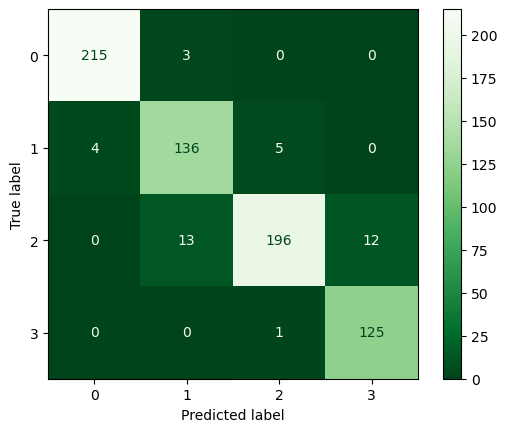

In [39]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot(cmap='Greens_r')
plt.savefig('../sql/forest_matrix.png', dpi=1200)
plt.show()

## Ranking the importance of features.
### First create a list of a list containing feature importances and feature names.

In [34]:
f_rankings = sorted(zip(model.feature_importances_,X.columns), reverse=True)
f_rankings

[(0.2081806116817245, 'Total_Population'),
 (0.11376629262662385, 'CO2_Emissions_by_Sector_Transportation'),
 (0.11125489110704455, 'CO2_Emissions_by_Sector_Land_Use_Change_and_Forestry'),
 (0.10954461588008342, 'Net_Electricity_Consumption'),
 (0.08502388554220192, 'CO2_Emissions_by_Sector_Bunker_Fuels'),
 (0.07103239527420041, 'CO2_Emissions_by_Sector_Energy'),
 (0.06805296208156264, 'CO2_Emissions_by_Sector_Electricity_Heat'),
 (0.06448158551566012, 'CO2_Emissions_by_Sector_Building'),
 (0.06322976903171514, 'CCO2_Emissions_by_Sector_Industrial_Processes'),
 (0.05365776572199779, 'CO2_Emissions_by_Sector_Other_Fuel_Combustion'),
 (0.05177522553718573, 'CO2_Emissions_by_Sector_Manufacturing_Construction')]

### Convert to a dataframe and replace long feature names with shortened versions.

In [35]:
rankings = pd.DataFrame(data=f_rankings, columns=['Ranking','Feature'])
rankings

,Ranking,Feature
0,0.208181,Total_Population
1,0.113766,CO2_Emissions_by_Sector_Transportation
2,0.111255,CO2_Emissions_by_Sector_Land_Use_Change_and_Fo...
3,0.109545,Net_Electricity_Consumption
4,0.085024,CO2_Emissions_by_Sector_Bunker_Fuels
5,0.071032,CO2_Emissions_by_Sector_Energy
6,0.068053,CO2_Emissions_by_Sector_Electricity_Heat
7,0.064482,CO2_Emissions_by_Sector_Building
8,0.063230,CCO2_Emissions_by_Sector_Industrial_Processes
9,0.053658,CO2_Emissions_by_Sector_Other_Fuel_Combustion


In [36]:
relabel = {rankings['Feature'][0]:'Total Pop',
         rankings['Feature'][1]:'Transportation',
         rankings['Feature'][2]:'Land Use Change',
         rankings['Feature'][3]:'Net Electricity Consumption',
         rankings['Feature'][4]:'Industrial Processes',
         rankings['Feature'][5]:'Bunker Fuels',
         rankings['Feature'][6]:'Electricity',
         rankings['Feature'][7]:'Building',
         rankings['Feature'][8]:'Manufacturing/Construction',
         rankings['Feature'][9]:'Energy Production',
         rankings['Feature'][10]:'Other Fuels'}
rankings_2 = rankings.replace(relabel)
rankings_2


,Ranking,Feature
0,0.208181,Total Pop
1,0.113766,Transportation
2,0.111255,Land Use Change
3,0.109545,Net Electricity Consumption
4,0.085024,Industrial Processes
5,0.071032,Bunker Fuels
6,0.068053,Electricity
7,0.064482,Building
8,0.063230,Manufacturing/Construction
9,0.053658,Energy Production


### Plotting the feature rankings as a bar graph

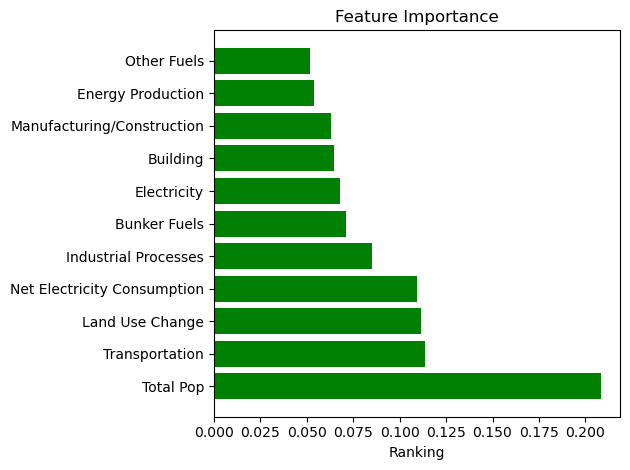

In [40]:
# plt.hbar(rankings_2['Feature'],rankings_2['Ranking'])
# plt.xticks(rotation=90)
fig, ax = plt.subplots()

ax.barh(rankings_2['Feature'],rankings_2['Ranking'],color='Green')
ax.set_yticks(rankings_2['Feature'], labels=rankings_2['Feature'])
ax.set_xlabel('Ranking')
ax.set_title('Feature Importance')
plt.tight_layout()
plt.savefig('../sql/forest_importance.png', dpi=1200)

## Tuning the model using grid search cross validation.

### Code taken from https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b

#### A grid is constructed with some arrays of parameters for the DecisionTreeClassifier(). The GridSearchCV object then runs a combination of each possible set of parameters and determines the best outcome based on accuracy score.

In [42]:
grid = {'n_estimators':[100,200,300,400,500],
        'max_features': ['sqrt','log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy'],
        'random_state':[78]
    }

gs = GridSearchCV(estimator=model,cv=5, param_grid=grid)

In [43]:
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=128,
                                              random_state=78),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [78]})

### gs.best_params_ tells us the parameters that achieved the highest accuracy score.

In [44]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 400,
 'random_state': 78}

### These parameters are then manually fed into the model and the results are analyzed below.

In [45]:
model_2 = RandomForestClassifier(
    criterion='entropy',
    max_depth=8,
    max_features='sqrt',
    n_estimators=400,
    random_state=78).fit(X_train_scaled, y_train)

In [46]:
predictions_2 = model_2.predict(X_test_scaled)

## Analysis of the 2nd model run with optimized parameters
### Curiously enough the accuracy score is significantly worse than the original. 

In [47]:
cm_2 = confusion_matrix(y_test, predictions_2)

cm_df_2 = pd.DataFrame(cm_2, index=["Actual 0", "Actual 1","Actual 2","Actual 3"], columns=["Predicted 0", "Predicted 1","Predicted 2","Predicted 3"])

acc_score_2 = accuracy_score(y_test, predictions_2)

print("Confusion Matrix")
display(cm_df_2)
print(f"Accuracy Score : {acc_score_2}")
print("Classification Report")
print(classification_report(y_test, predictions_2))

Confusion Matrix


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,210,8,0,0
Actual 1,5,131,9,0
Actual 2,2,15,189,15
Actual 3,0,0,3,123


Accuracy Score : 0.9197183098591549
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       218
           1       0.85      0.90      0.88       145
           2       0.94      0.86      0.90       221
           3       0.89      0.98      0.93       126

    accuracy                           0.92       710
   macro avg       0.91      0.92      0.92       710
weighted avg       0.92      0.92      0.92       710



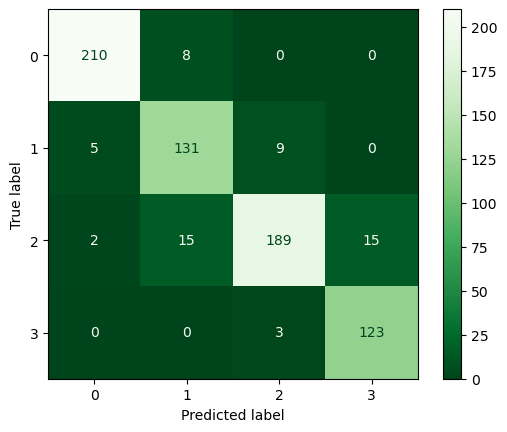

In [48]:
cm_display_2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_2)

cm_display_2.plot(cmap='Greens_r')
plt.savefig('../sql/forest_tuning.png', dpi=1200)
plt.show()